In [1]:
import os
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image
from PIL import UnidentifiedImageError

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
Parasitized= os.listdir('C:\\Users\\Nayee\\OneDrive\\Desktop\\ICFICE\\cell_images\\Parasitized')
Uninfected = os.listdir('C:\\Users\\Nayee\\OneDrive\\Desktop\\ICFICE\\cell_images\\Uninfected')

In [3]:
img_w, img_h = 75, 75
X = []
y = []

In [4]:
for i in Parasitized:
    try:
        img = Image.open("C:\\Users\\Nayee\\OneDrive\\Desktop\\ICFICE\\cell_images\\Parasitized\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass

In [5]:
for i in Uninfected :
    try:
        img = Image.open("C:\\Users\\Nayee\\OneDrive\\Desktop\\ICFICE\\cell_images\\Uninfected\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError:
        pass

In [6]:
X = np.asarray(X)
y = np.asarray(y)
print(X.shape, y.shape)

(27558, 75, 75, 3) (27558,)


In [7]:
x = X.astype('float32')
x /= 255

In [8]:
num_classes = 2

labels = keras.utils.to_categorical(y, num_classes)
print(labels[0])

[0. 1.]


In [9]:
x_train1, x_test, y_train1, y_test = train_test_split(x, labels, test_size = 0.1, random_state=5)
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,test_size=0.1,random_state=5)

print('Number of train: {}'.format(len(x_train)))
print('Number of validation: {}'.format(len(x_val)))
print('Number of test: {}'.format(len(x_test)))

Number of train: 22321
Number of validation: 2481
Number of test: 2756


In [10]:
#Augmentation

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=90.,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=30.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=0.2,
    vertical_flip=0.2,
    rescale=None)

datagen.fit(x_train)

In [11]:
#modelling
base_model = tf.keras.applications.InceptionV3(input_shape=(75,75,3),include_top=False,weights="imagenet")

In [12]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [22]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 dropout_1 (Dropout)         (None, 1, 1, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 22081826 (84.24 MB)
Trainable params: 27

In [25]:
model.save('model.h5')

In [27]:
import netron

# Open the SavedModel using Netron
netron.start('model.h5')


Serving 'model.h5' at http://localhost:8080


('localhost', 8080)

In [28]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [29]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [30]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-6)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=3)

In [31]:
model.compile(optimizer='Adam', loss = tf.keras.losses.BinaryCrossentropy(),metrics=METRICS)


In [32]:
%time
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/20
698/698 [==============================] - 55s 74ms/step - loss: 0.3201 - accuracy: 0.8604 - precision: 0.8605 - recall: 0.8602 - auc: 0.9374 - f1_score: 0.8603 - val_loss: 0.2630 - val_accuracy: 0.8879 - val_precision: 0.8892 - val_recall: 0.8863 - val_auc: 0.9583 - val_f1_score: 0.8884 - lr: 0.0010
Epoch 2/20
698/698 [==============================] - 54s 77ms/step - loss: 0.2736 - accuracy: 0.8834 - precision: 0.8834 - recall: 0.8835 - auc: 0.9546 - f1_score: 0.8834 - val_loss: 0.2432 - val_accuracy: 0.8978 - val_precision: 0.8961 - val_recall: 0.9000 - val_auc: 0.9644 - val_f1_score: 0.8987 - lr: 0.0010
Epoch 3/20
698/698 [==============================] - 54s 78ms/step - loss: 0.2584 - accuracy: 0.8919 - precision: 0.8915 - recall: 0.8925 - auc: 0.9594 - f1_score: 0.8920 - val_loss: 0.2421 - val_accuracy: 0.9008 - val_precision: 0.9015 - val_recall: 0.9000 - val_auc: 0.9655 - val_f1_score: 0.9014 - lr: 0.0010
Epoch 4/20
698/698 [==

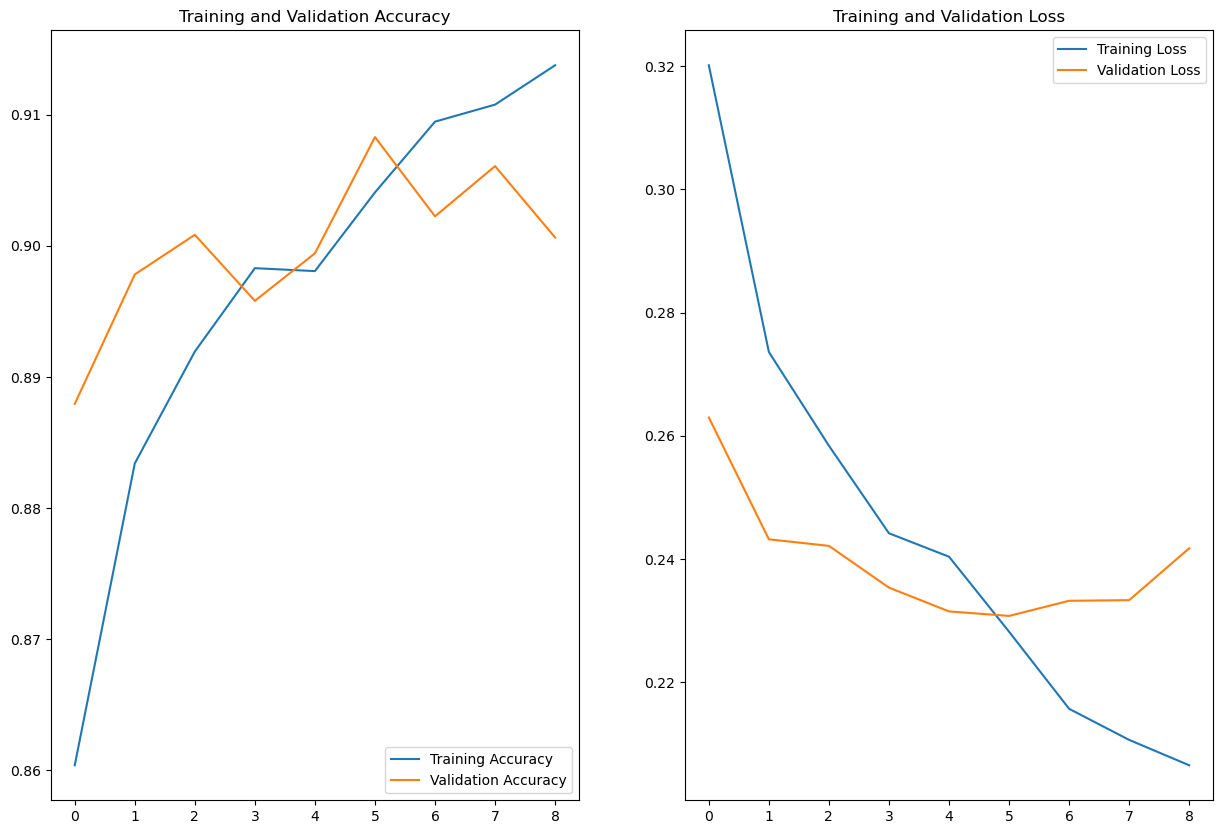

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

87/87 [==============================] - 5s 59ms/step
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

  Uninfected       0.85      0.91      0.88      1336
 Parasitized       0.91      0.85      0.88      1420

    accuracy                           0.88      2756
   macro avg       0.88      0.88      0.88      2756
weighted avg       0.88      0.88      0.88      2756



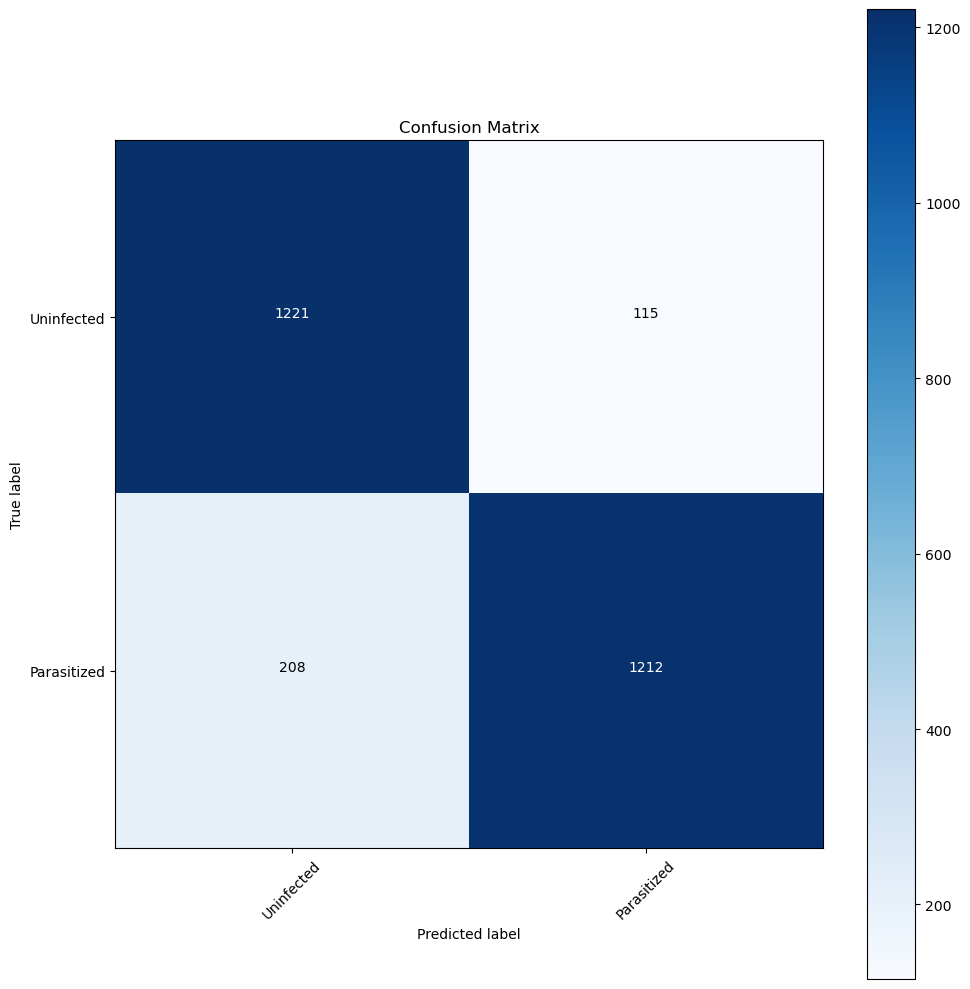

In [35]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")

y_test_c = np.argmax(y_test, axis=1)
target_names = ["Uninfected", "Parasitized"]

Y_pred = np.argmax(model.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))